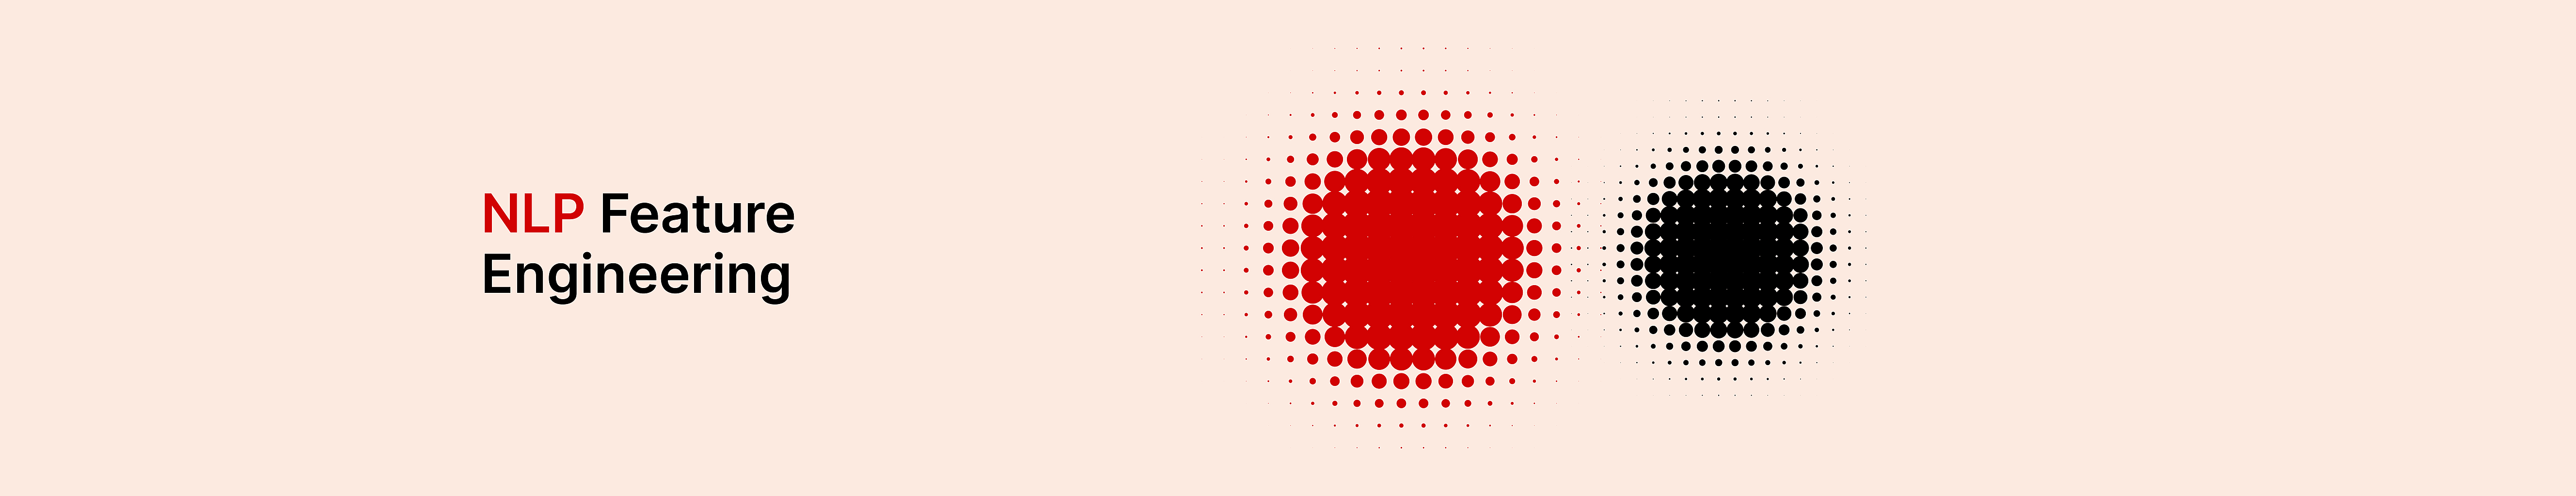

<h2><center>Starter Code for Feature Engineering</center></h2>

<!-- <h6><center>Author : Shubhamai</center></h6> -->



<!-- --- -->



### What we are going to Learn

  - How to convert your text into numbers ?
  - How Bag of words, TF-IDF, Word2Vec works ?
  - Testing and Submitting the Results to the Challenge. 

## About this Challanges

Now, this challange is very different form what we usually do in AIcrowd Blitz.In this challanges, the task is to generate features from a text data. So, what i mean by features ? it is simply to extract meaningful information about a text, let's take an example. 

```
Crop diseases are a major threat to food securit. The combination of increasing global smartphone
penetration and recent advances in computer vision made possible by deep
learning has paved the way for smartphone-assisted disease diagnosis. Using a
public dataset of 54,306 images of diseased and healthy plant leaves collected
under controlled conditions, we train a deep convolutional neural network to
identify 14 crop species and 26 diseases (or absence thereof). The trained
model achieves an accuracy of 99.35% on a held-out test set, demonstrating the
feasibility of this approach.Overall, the approach of training deep learning models on
increasingly large and publicly available image datasets presents a clear path
towards smartphone-assisted crop disease diagnosis on a massive global scale.
```

He we can see that the para seems contains words like images, neural network etc, with these features, we quickly figured out that this seems to be a rsearch paper Deep Learning & Computer Vision. Extracting features like these helps up to generate text embeddings will contains more useful information about the text. 


# Setup AIcrowd Utilities 🛠

We use this to bundle the files for submission and create a submission on AIcrowd. Do not edit this block.

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive') 
except:
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q -U aicrowd-cli

## How to use this notebook? 📝

<p style="text-align: center"><img src="https://gitlab.aicrowd.com/aicrowd/assets/-/raw/master/notebook/aicrowd_notebook_submission_flow.png?inline=false" alt="notebook overview" style="width: 650px;"/></p>

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data (The data will be available at `/data/` on aridhia workspace). This should be an absolute path.
`AICROWD_OUTPUTS_PATH` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#Install-packages-🗃) section to install the packages
- **Training your models**. All the code within the [Training phase ⚙️](#Training-phase-⚙️) section will be skipped during evaluation. **Please make sure to save your model weights in the assets directory and load them in the predictions phase section** 

## AIcrowd Runtime Configuration 🧷

Define configuration parameters. Please include any files needed for the notebook to run under `ASSETS_DIR`. We will copy the contents of this directory to your final submission file 🙂

The dataset is available under `/data` on the workspace.

In [3]:
import os

# Please use the absolute for the location of the dataset.
# Or you can use relative path with `os.getcwd() + "test_data/test.csv"`
AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", os.getcwd()+"/data/data.csv")
AICROWD_OUTPUTS_PATH = os.getenv("OUTPUTS_DIR", "")
AICROWD_ASSETS_DIR = os.getenv("ASSETS_DIR", "assets")

# Install packages 🗃

We are going to use many different libraries to demonstrate many idfferent techniques to convert text into numbers ( or more specifically vectors )

In [4]:
!pip install contractions
!pip install --upgrade spacy rich gensim tensorflow scikit-learn
!python -m spacy download en_core_web_sm # Downloaing the model for engligh language will contains many pretrained preprocessing pipelines 

Requirement already up-to-date: spacy in /usr/local/lib/python3.7/dist-packages (3.0.6)
Requirement already up-to-date: rich in /usr/local/lib/python3.7/dist-packages (10.4.0)
Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.5.0)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)
2021-06-26 20:02:46.475921: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Define preprocessing code 💻

The code that is common between the training and the prediction sections should be defined here. During evaluation, we completely skip the training section. Please make sure to add any common logic between the training and prediction sections here.

In [5]:
# Importing Libraries
import pandas as pd
import numpy as np
import pickle

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
import random
import contractions
import re
from tqdm.notebook import tqdm

# Tensorflow 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# Word2vec Implementation
import spacy
nlp = spacy.load('en_core_web_sm', exclude=['tagger', 'ner', 'attribute_ruler', 'lemmatizer'])

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

# To make things more beautiful! 
from rich.console import Console
from rich.table import Table
from rich.segment import Segment
from rich import pretty
pretty.install()

# Seeding everything for getting same results 
random.seed(42)
np.random.seed(42)

# function to display YouTube videos
from IPython.display import YouTubeVideo

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [6]:
# Latest version of gensim
import gensim
gensim.__version__

'4.0.1'

In [7]:
# # Defining the function for preprocessing test dataset which will run after submitting the notebook

def preprocess_pipeline(text):
  '''
      Step 1:- Replace contractions 
      Step 2:- Remove all Punctuations.
      Step 3:- Remove all Numbers.
      Step 4:- Remove all Emoticons.
  '''

  ### remove contractions

  text = contractions.fix(text)

  ### remove punctutations 

  text = re.sub(r'[^\w\s]', '', text)

  ### Remove all numbers 

  text = re.sub(r'[0-9]+', '', text)

  ### Remove all emoticons and smileys 
  regrex_pattern = re.compile(pattern = "["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                                "]+", flags = re.UNICODE)
  text = regrex_pattern.sub(r'',text)

  consider = []
  for word in text.split():
    if len(word)>1:
      consider.append(word)

  return ' '.join(consider)

def tokenize_sentence(sentences): 
  tf_model  = TfidfVectorizer(max_features=512,ngram_range=(1,2),
                              lowercase=True,stop_words='english')
  

  prep_sentences = [preprocess_pipeline(sent) for sent in sentences]

  X         = tf_model.fit_transform(prep_sentences)

  X         = np.array(X.todense())

  X         = np.round(X*5).astype(int)

  return X,tf_model


# Training phase ⚙️

You can define your training code here. This sections will be skipped during evaluation.

## Downloading Dataset

Must be prety familar thing by now :) In case, here we are downloading the challange dataset using AIcrowd CLI 

API Key valid
Saved API Key successfully!


In [9]:
# Downloading the Dataset
!mkdir data

# Donwloading emotion classification dataset for testing purposes
!mkdir emotion-detection-data


mkdir: cannot create directory ‘data’: File exists
data.csv: 100% 110k/110k [00:00<00:00, 1.10MB/s]
mkdir: cannot create directory ‘emotion-detection-data’: File exists
train.csv:   0% 0.00/2.30M [00:00<?, ?B/s]
val.csv:   0% 0.00/262k [00:00<?, ?B/s]

test.csv:   0% 0.00/642k [00:00<?, ?B/s]
val.csv: 100% 262k/262k [00:00<00:00, 1.75MB/s]


test.csv: 100% 642k/642k [00:00<00:00, 3.19MB/s]
train.csv: 100% 2.30M/2.30M [00:00<00:00, 7.27MB/s]


### Reading Dataset

Reading the necessary files to train, validation & submit our results! 

We are also using [Emotion Detection Challange](https://www.aicrowd.com/challenges/ai-blitz-9/problems/emotion-detection) dataset for testing purposes.

In [10]:
dataset = pd.read_csv("/content/data.csv")
train_data1 = pd.read_csv("emotion-detection-data/train.csv")
train_dataset = train_data1.copy()
### traindata2 is data for problem 2 
train_data2 = pd.read_csv('/content/train.csv')

test_data1  = pd.read_csv("emotion-detection-data/test.csv")
test_data2  = pd.read_csv('/content/test.csv')

val_data1   = pd.read_csv("emotion-detection-data/val.csv")
val_data2   = pd.read_csv('/content/val.csv')

dataset

id 
 text 
 feature 
 
 
 
 
 0 
 0 
 Zero-divisors (ZDs) derived by Cayley-Dickson ... 
 [0.3745401188473625, 0.9507143064099162, 0.731... 
 
 
 1 
 1 
 This paper is an exposition of the so-called i... 
 [0.9327284833540133, 0.8660638895004084, 0.045... 
 
 
 2 
 2 
 Zero-divisors (ZDs) derived by Cayley-Dickson ... 
 [0.9442664891134339, 0.47421421665746377, 0.86... 
 
 
 3 
 3 
 We calculate the equation of state of dense hy... 
 [0.18114934953468032, 0.6811178539649828, 0.18... 
 
 
 4 
 4 
 The Donald-Flanigan conjecture asserts that fo... 
 [0.5435382173426461, 0.08172534574677826, 0.45... 
 
 
 5 
 5 
 Let $E$ be a primarily quasilocal field, $M/E$... 
 [0.7945155444907487, 0.7070864772666982, 0.050... 
 
 
 6 
 6 
 The paper deals with the study of labor market... 
 [0.3129073942136482, 0.27109625376406576, 0.59... 
 
 
 7 
 7 
 Axisymmetric equilibria with incompressible fl... 
 [0.40680480095172356, 0.3282331056783394, 0.45... 
 
 
 8 
 8 
 This paper analyses the possibilities of perfo... 
 [0.013682414760681105, 0.08159872000483837, 0.... 
 
 
 9 
 9 
 I show that an (n+2)-dimensional n-Lie algebra... 
 [0.9562918815133613, 0.37667644042946247, 0.33...

## Creating our Templete

So, with this `train_model` we are going to text the various differetn techniques and pare to see which works best!

In [11]:
def train_model(X, y):

  # Splitting the dataset into training and testing,  also by using stratify, we are making sure to use the same class balance between training and testing. 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

  # Creating and training sklearn's Decision Tree Classifier Model 
  from sklearn.linear_model import LogisticRegression
  clf = DecisionTreeClassifier(random_state=42)
  clf.fit(X_train, y_train)

  # Getting the predictions form unseen (testing dataset)
  predictions = clf.predict(X_test)

  # Calcuating the metrics 
  f1 = f1_score(y_test, predictions, average='weighted')
  accuracy = accuracy_score(y_test, predictions)

  # Creating the table
  console = Console()
  result_table = Table(show_header=False, header_style="bold magenta")

  result_table.add_row("F1 Score", str(f1))
  result_table.add_row("Accuracy Score", str(accuracy))

  # Showing the table
  console.print(result_table)

  return f1, accuracy

## Simple Tokenization 🪙

Here, all what we are doing is splitting the senteces into tokens/words, and then assigning a unique id to each token, and here we go, we converted the text into a vector. We are also using padding to make sure all vectors are of `maxlen` which is 512. 

In [12]:
# def tokenize_sentence(sentences, num_words=512, maxlen=512, show=False): 

#   # Creating the tokenizer, the num_words represents the vocabulary and assigning OOV token ( out of vocaculary ) for unknown tokenn
#   # Which can arise if we input a sentence containing a words that tokenizer don't have in his vocabulary

#   tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")


#   tokenizer.fit_on_texts(sentences)
  
#   # Getting the unique ID for each token
#   word_index = tokenizer.word_index

#   # Convert the senteces into vector
#   sequences = tokenizer.texts_to_sequences(sentences)

#   # Padding the vectors so that all vectors have the same length
#   padded_sequences = pad_sequences(sequences, padding='post', truncating='pre', maxlen=maxlen)


#   word_index = np.asarray(word_index)
#   sequences = np.asarray(sequences)
#   padded_sequences = np.asarray(padded_sequences)

#   if show==True:
#     console = Console()

#     console.log("Word Index. A unique ID is assigned to each token.")
#     console.log(word_index)
#     console.log("---"*10)

#     console.log("Sequences. senteces converted into vector.")
#     console.log(np.array(sequences[0]))
#     console.log("---"*10)

#     console.log("Padded Sequences. Adding,( 0 in this case ) or removing elements to make all vectors in the samples same.")
#     console.log(np.array(padded_sequences[0]))
#     console.log("---"*10)



#   return tokenizer, word_index, sequences, padded_sequences


# Defining the function for preprocessing test dataset which will run after submitting the notebook



def preprocess_pipeline(text):
  '''
      Step 1:- Replace contractions 
      Step 2:- Remove all Punctuations.
      Step 3:- Remove all Numbers.
      Step 4:- Remove all Emoticons.
  '''

  ### remove contractions

  text = contractions.fix(text)

  ### remove punctutations 

  text = re.sub(r'[^\w\s]', '', text)

  ### Remove all numbers 

  text = re.sub(r'[0-9]+', '', text)

  ### Remove all emoticons and smileys 
  regrex_pattern = re.compile(pattern = "["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                                "]+", flags = re.UNICODE)
  text = regrex_pattern.sub(r'',text)

  consider = []
  for word in text.split():
    if len(word)>1:
      consider.append(word)

  return ' '.join(consider)

def tokenize_sentence(sentences): 
  tf_model  = TfidfVectorizer(max_features=512,ngram_range=(1,2),
                              lowercase=True,stop_words='english')
  

  prep_sentences = [preprocess_pipeline(sent) for sent in sentences]

  X         = tf_model.fit_transform(prep_sentences)

  X         = np.array(X.todense())

  X         = np.round(X*5).astype(int)

  return X,tf_model



In [13]:
# Sample Senteces
sample_sentences = dataset.iloc[0, 1].split(".")
sample_sentences

[
    'Zero-divisors (ZDs) derived by Cayley-Dickson Process (CDP) from\nN-dimensional hypercomplex numbers (N a power of 2, at least 4) can represent\nsingularities and, as N approaches infinite, fractals -- and thereby,scale-free\nnetworks',
    ' Any integer greater than 8 and not a power of 2 generates a\nmeta-fractal or "Sky" when it is interpreted as the "strut constant" (S) of an\nensemble of octahedral vertex figures called "Box-Kites" (the fundamental\nbuilding blocks of ZDs)',
    ' Remarkably simple bit-manipulation rules or "recipes"\nprovide tools for transforming one fractal genus into others within the context\nof Wolfram\'s Class 4 complexity',
    ''
]

In [14]:
_, _,  = tokenize_sentence(sample_sentences)

In [15]:
# Training the model using the vectors and the features
train1 = train_data1['text'].values.tolist()
# train2 = train_data2['text'].values.tolist()
test1  = test_data1['text'].values.tolist()
# test2  = test_data2['text'].values.tolist()
val1   = val_data1['text'].values.tolist()
# val2   = val_data2['text'].values.tolist()

# train1.extend(train2)
# test1.extend(test2)
# val1.extend(val2)

train1.extend(test1)
train1.extend(val1)

to_use = train1.copy()
# X,model2use = tokenize_sentence(to_use)
# tokenizer, _, _, _ = tokenize_sentence(to_use,num_words=512)

# X = tokenizer.texts_to_matrix(train_data1['text'].values.tolist())
# y = train_data1['label'].values
# print(X.shape,y.shape)

In [16]:
# !mkdir assets
# import pickle
# filename = '/content/assets/finalized_model.sav'
# pickle.dump(model2use, open(filename, 'wb'))

In [17]:
# print("Sentence : ", train_data1['text'][2])
# print("Simple Tokenizer : ", X[2])
# import gc
# gc.collect()

X,_ = tokenize_sentence(train_data1['text'].values.tolist())
y = train_data1['label'].values
X.shape,y.shape

((31255, 512), (31255,))

In [18]:
np.unique(X)

array([0, 1, 2, 3, 4, 5])

In [ ]:
token_id_f1, token_id_accuracy = train_model(X, y)

# Prediction phase 🔎

Generating the features in test dataset. 

In [20]:
test_dataset = pd.read_csv(AICROWD_DATASET_PATH)

test_dataset

id 
 text 
 feature 
 
 
 
 
 0 
 0 
 Zero-divisors (ZDs) derived by Cayley-Dickson ... 
 [0.3745401188473625, 0.9507143064099162, 0.731... 
 
 
 1 
 1 
 This paper is an exposition of the so-called i... 
 [0.9327284833540133, 0.8660638895004084, 0.045... 
 
 
 2 
 2 
 Zero-divisors (ZDs) derived by Cayley-Dickson ... 
 [0.9442664891134339, 0.47421421665746377, 0.86... 
 
 
 3 
 3 
 We calculate the equation of state of dense hy... 
 [0.18114934953468032, 0.6811178539649828, 0.18... 
 
 
 4 
 4 
 The Donald-Flanigan conjecture asserts that fo... 
 [0.5435382173426461, 0.08172534574677826, 0.45... 
 
 
 5 
 5 
 Let $E$ be a primarily quasilocal field, $M/E$... 
 [0.7945155444907487, 0.7070864772666982, 0.050... 
 
 
 6 
 6 
 The paper deals with the study of labor market... 
 [0.3129073942136482, 0.27109625376406576, 0.59... 
 
 
 7 
 7 
 Axisymmetric equilibria with incompressible fl... 
 [0.40680480095172356, 0.3282331056783394, 0.45... 
 
 
 8 
 8 
 This paper analyses the possibilities of perfo... 
 [0.013682414760681105, 0.08159872000483837, 0.... 
 
 
 9 
 9 
 I show that an (n+2)-dimensional n-Lie algebra... 
 [0.9562918815133613, 0.37667644042946247, 0.33...

In [23]:
# # So, let's do a simple tokenization and generate the features!
X,_ = tokenize_sentence(test_dataset['text'].values)



# X = tokenizer.texts_to_matrix(test_dataset['text'].values, mode='tfidf')

# Creating the wor2vec model, size is the output vector size of each word

for index, row in tqdm(test_dataset.iterrows()):
  test_dataset.iloc[index, 2] = str(X[index].tolist())

test_dataset

0it [00:00, ?it/s]

id 
 text 
 feature 
 
 
 
 
 0 
 0 
 Zero-divisors (ZDs) derived by Cayley-Dickson ... 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 
 
 
 1 
 1 
 This paper is an exposition of the so-called i... 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 
 
 
 2 
 2 
 Zero-divisors (ZDs) derived by Cayley-Dickson ... 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 
 
 
 3 
 3 
 We calculate the equation of state of dense hy... 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 
 
 
 4 
 4 
 The Donald-Flanigan conjecture asserts that fo... 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 
 
 
 5 
 5 
 Let $E$ be a primarily quasilocal field, $M/E$... 
 [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ... 
 
 
 6 
 6 
 The paper deals with the study of labor market... 
 [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ... 
 
 
 7 
 7 
 Axisymmetric equilibria with incompressible fl... 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 
 
 
 8 
 8 
 This paper analyses the possibilities of perfo... 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 
 
 
 9 
 9 
 I show that an (n+2)-dimensional n-Lie algebra... 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [24]:
len(eval(test_dataset['feature'][0]))

512

In [25]:
# Saving the sample submission
test_dataset.to_csv(os.path.join(AICROWD_OUTPUTS_PATH,'submission.csv'), index=False)

# Submit to AIcrowd 🚀

**Note : Please save the notebook before submitting it (Ctrl + S)**

In [26]:
!DATASET_PATH=$AICROWD_DATASET_PATH \
aicrowd -v notebook submit \
    --assets-dir $AICROWD_ASSETS_DIR \
    --challenge nlp-feature-engineering

Using notebook: /content/drive/MyDrive/Colab Notebooks/trial_feat_eng_roughwork.ipynb for submission...
Removing existing files from submission directory...
Scrubbing API keys from the notebook...
Validating the submission...
Executing install.ipynb...
[NbConvertApp] Converting notebook /content/submission/install.ipynb to notebook
[NbConvertApp] Executing notebook with kernel: python3
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] Writing 28731 bytes to /content/submission/install.nbconvert.ipynb
Executi

Congratulations 🎉 you did it, but there still a lot of improvement that can be made, this is feature engineering challange after all, means that we have to fit as much information as we can about the text in `512` numbers. We only covered converting texts into vector, but there are so many things you can try more, for ex. unsupervised classification, idk, maybe it can help :)

And btw -

> Don't be shy to ask question related to any errors you are getting or doubts in any part of this notebook in [discussion forum](https://www.aicrowd.com/challenges/ai-blitz-9/problems/nlp-feature-engineering/discussion) or in [AIcrowd Discord sever](https://discord.gg/T6uZSWBMSZ), AIcrew will be happy to help you :)

Also, wanna give us your valuable feedback for next blitz or wanna work with us creating blitz challanges ? Let us know! 